# PreTrain

In [1]:
from model.sswae_dev2 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params, calculate_sharpness
from XAE.sampler import gaus
from XAE.logging_daily import logging_daily
import XAE.fid as fid
from random import sample

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 5

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 25
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.575
[2] loss: 0.530
[3] loss: 0.287
[4] loss: 0.094
[5] loss: 0.039
[6] loss: 0.024
[7] loss: 0.016
[8] loss: 0.011
[9] loss: 0.011
[10] loss: 0.009
[11] loss: 0.007
[12] loss: 0.007
[13] loss: 0.007
[14] loss: 0.005
[15] loss: 0.006
[16] loss: 0.004
[17] loss: 0.004
[18] loss: 0.005
[19] loss: 0.003
[20] loss: 0.006
[21] loss: 0.004
[22] loss: 0.004
[23] loss: 0.002
[24] loss: 0.001
[25] loss: 0.002


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 5])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

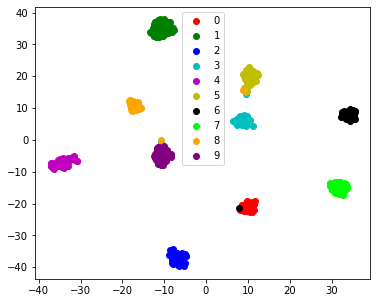

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

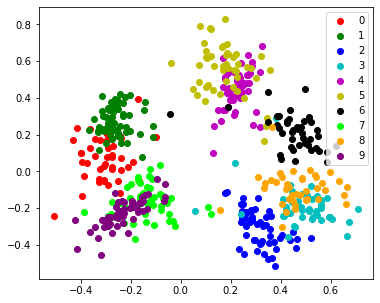

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()

In [12]:
w = torch.Tensor(ys.transpose()/cs)
w

tensor([[-0.2877, -0.2674,  0.2975,  0.4776,  0.2264,  0.1463,  0.4330, -0.1668,
          0.4439, -0.2425],
        [ 0.4054,  0.3449,  0.6021, -0.3323, -0.2778, -0.2903, -0.1841, -0.1977,
          0.3313, -0.1145],
        [ 0.0732,  0.2968, -0.2859, -0.1807,  0.4743,  0.5806,  0.2334, -0.1398,
         -0.0865, -0.2285],
        [-0.3143,  0.3282,  0.4604,  0.2612,  0.6172, -0.2613, -0.1407,  0.2891,
         -0.3162,  0.5120],
        [ 0.3883, -0.1103,  0.2051, -0.2036,  0.0668, -0.3783,  0.4569,  0.6003,
         -0.3134, -0.2391]])

In [13]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w
torch.save(f1.state_dict(), f'./result/f1_{y_dim}.pt')

# Train

In [14]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_6.cfg')

['./config/sswae_dev2_6.cfg']

In [15]:
mm = cur_model(cfg, log, device = device)
mm.f1.load_state_dict(torch.load(f'./result/f1_{y_dim}.pt'))
mm.train()

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 6
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 5
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [001/100]  loss: 2.404789e-01  D: 6.896145e-01  D2: 4.934832e-02  D3: 3.918060e-03
test loss: 1.871044e-01  D: 6.892077e-01  D2: 2.315584e-02  D3: 6.017270e-03


[default |INFO|model.py:1280] [002/100]  loss: 1.741346e-01  D: 6.933289e-01  D2: 1.713353e-02  D3: 7.150034e-03
test loss: 1.638654e-01  D: 6.955541e-01  D2: 3.836098e-03  D3: 8.022358e-03


[default |INFO|model.py:1280] [003/100]  loss: 1.596955e-01  D: 6.972326e-01  D2: -1.040560e-03  D3: 8.909637e-03
test loss: 1.402669e-01  D: 6.833175e-01  D2: -3.410053e-03  D3: 7.562198e-03


[default |INFO|model.py:1280] [004/100]  loss: 1.238729e-01  D: 6.937900e-01  D2: -3.660526e-03  D3: 7.458285e-03
test loss: 1.119971e-01  D: 7.049413e-01  D2: -4.938135e-03  D3: 6.578577e-03


[default |INFO|model.py:1280] [005/100]  loss: 1.166149e-01  D: 6.998173e-01  D2: -4.224027e-03  D3: 1.085780e-02
test loss: 1.342608e-01  D: 6.944414e-01  D2: -4.385967e-03  D3: 1.364176e-02


[default |INFO|model.py:1280] [006/100]  loss: 1.167059e-01  D: 6.972279e-01  D2: -4.158268e-03  D3: 1.607680e-02
test loss: 9.678976e-02  D: 6.877538e-01  D2: -4.614391e-03  D3: 1.643439e-02


[default |INFO|model.py:1280] [007/100]  loss: 1.014853e-01  D: 6.964416e-01  D2: -4.486801e-03  D3: 1.749598e-02
test loss: 9.197228e-02  D: 7.045733e-01  D2: -5.580921e-03  D3: 1.776206e-02


[default |INFO|model.py:1280] [008/100]  loss: 8.776356e-02  D: 6.936430e-01  D2: -5.000353e-03  D3: 1.721484e-02
test loss: 8.121716e-02  D: 7.058837e-01  D2: -5.801220e-03  D3: 1.676201e-02


[default |INFO|model.py:1280] [009/100]  loss: 8.200958e-02  D: 6.940676e-01  D2: -5.134805e-03  D3: 1.721470e-02
test loss: 7.615384e-02  D: 7.012644e-01  D2: -4.639091e-03  D3: 1.522167e-02


[default |INFO|model.py:1280] [010/100]  loss: 7.792015e-02  D: 6.942233e-01  D2: -5.270362e-03  D3: 1.737071e-02
test loss: 7.412006e-02  D: 7.146801e-01  D2: -5.482559e-03  D3: 1.719196e-02


[default |INFO|model.py:1280] [011/100]  loss: 7.449063e-02  D: 6.935275e-01  D2: -5.448049e-03  D3: 1.679916e-02
test loss: 7.234274e-02  D: 6.847919e-01  D2: -5.105829e-03  D3: 1.682753e-02


[default |INFO|model.py:1280] [012/100]  loss: 7.275406e-02  D: 6.935946e-01  D2: -5.523527e-03  D3: 1.601900e-02
test loss: 7.093131e-02  D: 6.887269e-01  D2: -5.314598e-03  D3: 1.553775e-02


[default |INFO|model.py:1280] [013/100]  loss: 7.184372e-02  D: 6.953387e-01  D2: -5.547606e-03  D3: 1.618320e-02
test loss: 6.824929e-02  D: 6.838491e-01  D2: -5.398951e-03  D3: 1.775276e-02


[default |INFO|model.py:1280] [014/100]  loss: 6.857474e-02  D: 6.937916e-01  D2: -5.991260e-03  D3: 1.649802e-02
test loss: 6.737194e-02  D: 6.699981e-01  D2: -5.457554e-03  D3: 1.611052e-02


[default |INFO|model.py:1280] [015/100]  loss: 6.656159e-02  D: 6.935505e-01  D2: -5.974800e-03  D3: 1.652857e-02
test loss: 6.475707e-02  D: 6.952761e-01  D2: -6.792765e-03  D3: 1.762112e-02


[default |INFO|model.py:1280] [016/100]  loss: 6.655712e-02  D: 6.938019e-01  D2: -6.335039e-03  D3: 1.617195e-02
test loss: 6.527769e-02  D: 6.588271e-01  D2: -5.948439e-03  D3: 1.745879e-02


[default |INFO|model.py:1280] [017/100]  loss: 6.579996e-02  D: 6.944698e-01  D2: -6.217397e-03  D3: 1.546732e-02
test loss: 6.587163e-02  D: 7.045214e-01  D2: -6.625051e-03  D3: 1.155466e-02


[default |INFO|model.py:1280] [018/100]  loss: 6.634099e-02  D: 6.941857e-01  D2: -6.543759e-03  D3: 1.588847e-02
test loss: 6.424115e-02  D: 7.132968e-01  D2: -6.411905e-03  D3: 1.361411e-02


[default |INFO|model.py:1280] [019/100]  loss: 6.719046e-02  D: 6.947547e-01  D2: -6.451974e-03  D3: 1.474146e-02
test loss: 6.579964e-02  D: 7.074327e-01  D2: -6.797352e-03  D3: 1.166866e-02


[default |INFO|model.py:1280] [020/100]  loss: 6.407215e-02  D: 6.941266e-01  D2: -6.697133e-03  D3: 1.559770e-02
test loss: 6.409791e-02  D: 6.955986e-01  D2: -7.004576e-03  D3: 1.645775e-02


[default |INFO|model.py:1280] [021/100]  loss: 6.154697e-02  D: 6.932214e-01  D2: -6.782851e-03  D3: 1.609156e-02
test loss: 6.115567e-02  D: 6.700281e-01  D2: -7.406816e-03  D3: 1.608929e-02


[default |INFO|model.py:1280] [022/100]  loss: 6.169693e-02  D: 6.945382e-01  D2: -6.981854e-03  D3: 1.563857e-02
test loss: 6.087637e-02  D: 7.050728e-01  D2: -7.004881e-03  D3: 1.704668e-02


[default |INFO|model.py:1280] [023/100]  loss: 6.063705e-02  D: 6.936268e-01  D2: -7.014144e-03  D3: 1.576564e-02
test loss: 6.119065e-02  D: 7.143717e-01  D2: -8.077536e-03  D3: 1.591895e-02


[default |INFO|model.py:1280] [024/100]  loss: 5.947488e-02  D: 6.937006e-01  D2: -7.415722e-03  D3: 1.568974e-02
test loss: 5.898453e-02  D: 6.913706e-01  D2: -7.735157e-03  D3: 1.604271e-02


[default |INFO|model.py:1280] [025/100]  loss: 5.964946e-02  D: 6.936855e-01  D2: -7.473343e-03  D3: 1.570087e-02
test loss: 6.040068e-02  D: 6.963992e-01  D2: -7.501516e-03  D3: 1.709773e-02


[default |INFO|model.py:1280] [026/100]  loss: 5.946968e-02  D: 6.937719e-01  D2: -7.611868e-03  D3: 1.549147e-02
test loss: 5.941836e-02  D: 6.874896e-01  D2: -8.004351e-03  D3: 1.528056e-02


[default |INFO|model.py:1280] [027/100]  loss: 5.944419e-02  D: 6.938386e-01  D2: -7.610869e-03  D3: 1.531922e-02
test loss: 5.953773e-02  D: 6.997258e-01  D2: -8.417044e-03  D3: 1.589941e-02


[default |INFO|model.py:1280] [028/100]  loss: 5.947620e-02  D: 6.935144e-01  D2: -7.907292e-03  D3: 1.543113e-02
test loss: 5.833345e-02  D: 6.856199e-01  D2: -7.741327e-03  D3: 1.399486e-02


[default |INFO|model.py:1280] [029/100]  loss: 5.945514e-02  D: 6.941708e-01  D2: -8.065267e-03  D3: 1.513676e-02
test loss: 6.287884e-02  D: 6.906803e-01  D2: -7.895498e-03  D3: 1.532057e-02


[default |INFO|model.py:1280] [030/100]  loss: 5.991373e-02  D: 6.928836e-01  D2: -8.106716e-03  D3: 1.511266e-02
test loss: 5.880048e-02  D: 6.889217e-01  D2: -8.114719e-03  D3: 1.653679e-02


[default |INFO|model.py:1280] [031/100]  loss: 5.800558e-02  D: 6.941115e-01  D2: -8.292212e-03  D3: 1.537296e-02
test loss: 5.904957e-02  D: 6.885990e-01  D2: -8.145914e-03  D3: 1.503469e-02


[default |INFO|model.py:1280] [032/100]  loss: 5.826077e-02  D: 6.937185e-01  D2: -8.122466e-03  D3: 1.512345e-02
test loss: 5.775709e-02  D: 6.838336e-01  D2: -8.291054e-03  D3: 1.613543e-02


[default |INFO|model.py:1280] [033/100]  loss: 5.750558e-02  D: 6.931184e-01  D2: -8.279026e-03  D3: 1.528657e-02
test loss: 5.891367e-02  D: 6.831306e-01  D2: -8.919153e-03  D3: 1.387383e-02


[default |INFO|model.py:1280] [034/100]  loss: 5.817789e-02  D: 6.938446e-01  D2: -8.528196e-03  D3: 1.496467e-02
test loss: 5.968992e-02  D: 6.890772e-01  D2: -9.135828e-03  D3: 1.519033e-02


[default |INFO|model.py:1280] [035/100]  loss: 5.965823e-02  D: 6.939878e-01  D2: -8.540494e-03  D3: 1.463799e-02
test loss: 6.092485e-02  D: 6.840207e-01  D2: -8.624744e-03  D3: 1.329463e-02


[default |INFO|model.py:1280] [036/100]  loss: 5.732291e-02  D: 6.935374e-01  D2: -8.805820e-03  D3: 1.507279e-02
test loss: 5.918271e-02  D: 6.782246e-01  D2: -9.355516e-03  D3: 1.415640e-02


[default |INFO|model.py:1280] [037/100]  loss: 5.695842e-02  D: 6.936581e-01  D2: -9.080598e-03  D3: 1.492152e-02
test loss: 5.762574e-02  D: 7.002121e-01  D2: -8.347540e-03  D3: 1.272637e-02


[default |INFO|model.py:1280] [038/100]  loss: 5.713293e-02  D: 6.937783e-01  D2: -8.884007e-03  D3: 1.505874e-02
test loss: 5.925939e-02  D: 6.982461e-01  D2: -9.521894e-03  D3: 1.327576e-02


[default |INFO|model.py:1280] [039/100]  loss: 5.676039e-02  D: 6.934558e-01  D2: -9.056815e-03  D3: 1.480696e-02
test loss: 5.782538e-02  D: 6.925047e-01  D2: -8.781796e-03  D3: 1.205714e-02


[default |INFO|model.py:1280] [040/100]  loss: 5.730206e-02  D: 6.934517e-01  D2: -9.181490e-03  D3: 1.476966e-02
test loss: 5.895585e-02  D: 6.811682e-01  D2: -9.382582e-03  D3: 1.758867e-02


[default |INFO|model.py:1280] [041/100]  loss: 5.674564e-02  D: 6.930291e-01  D2: -9.332614e-03  D3: 1.474881e-02
test loss: 5.774215e-02  D: 6.985227e-01  D2: -9.635715e-03  D3: 1.463349e-02


[default |INFO|model.py:1280] [042/100]  loss: 5.749985e-02  D: 6.943009e-01  D2: -9.341660e-03  D3: 1.447026e-02
test loss: 6.037382e-02  D: 6.996639e-01  D2: -9.034147e-03  D3: 1.109559e-02


[default |INFO|model.py:1280] [043/100]  loss: 5.662007e-02  D: 6.937736e-01  D2: -9.410478e-03  D3: 1.434929e-02
test loss: 5.662785e-02  D: 7.091236e-01  D2: -9.316196e-03  D3: 1.284064e-02


[default |INFO|model.py:1280] [044/100]  loss: 5.598111e-02  D: 6.950068e-01  D2: -9.526512e-03  D3: 1.470618e-02
test loss: 5.742752e-02  D: 6.825840e-01  D2: -9.612103e-03  D3: 1.479328e-02


[default |INFO|model.py:1280] [045/100]  loss: 5.741679e-02  D: 6.944072e-01  D2: -9.571648e-03  D3: 1.432551e-02
test loss: 5.837179e-02  D: 6.944833e-01  D2: -9.675121e-03  D3: 1.160842e-02


[default |INFO|model.py:1280] [046/100]  loss: 5.733571e-02  D: 6.933681e-01  D2: -9.758113e-03  D3: 1.431858e-02
test loss: 5.685668e-02  D: 7.064783e-01  D2: -9.732447e-03  D3: 1.676657e-02


[default |INFO|model.py:1280] [047/100]  loss: 5.621758e-02  D: 6.931071e-01  D2: -9.765407e-03  D3: 1.455940e-02
test loss: 5.808499e-02  D: 6.967229e-01  D2: -9.777050e-03  D3: 1.418071e-02


[default |INFO|model.py:1280] [048/100]  loss: 5.668241e-02  D: 6.931707e-01  D2: -9.764304e-03  D3: 1.462677e-02
test loss: 5.879439e-02  D: 6.862508e-01  D2: -1.019619e-02  D3: 1.538000e-02


[default |INFO|model.py:1280] [049/100]  loss: 5.623202e-02  D: 6.931696e-01  D2: -1.004772e-02  D3: 1.442181e-02
test loss: 5.889254e-02  D: 6.969081e-01  D2: -9.745626e-03  D3: 1.355821e-02


[default |INFO|model.py:1280] [050/100]  loss: 5.556247e-02  D: 6.938413e-01  D2: -9.985352e-03  D3: 1.462288e-02
test loss: 5.705926e-02  D: 6.814961e-01  D2: -9.321203e-03  D3: 1.432184e-02


[default |INFO|model.py:1280] [051/100]  loss: 5.670864e-02  D: 6.924475e-01  D2: -1.000442e-02  D3: 1.431499e-02
test loss: 5.951420e-02  D: 6.887168e-01  D2: -9.882355e-03  D3: 1.268004e-02


[default |INFO|model.py:1280] [052/100]  loss: 5.605439e-02  D: 6.933549e-01  D2: -1.022788e-02  D3: 1.451722e-02
test loss: 5.761380e-02  D: 6.958693e-01  D2: -1.062500e-02  D3: 1.392021e-02


[default |INFO|model.py:1280] [053/100]  loss: 5.580923e-02  D: 6.930205e-01  D2: -1.017612e-02  D3: 1.455217e-02
test loss: 5.791084e-02  D: 6.919503e-01  D2: -1.053508e-02  D3: 1.277336e-02


[default |INFO|model.py:1280] [054/100]  loss: 5.620790e-02  D: 6.941008e-01  D2: -1.029178e-02  D3: 1.448570e-02
test loss: 5.738506e-02  D: 6.931465e-01  D2: -1.004059e-02  D3: 1.470770e-02


[default |INFO|model.py:1280] [055/100]  loss: 5.595494e-02  D: 6.945570e-01  D2: -1.027598e-02  D3: 1.413015e-02
test loss: 5.831487e-02  D: 7.036337e-01  D2: -1.039024e-02  D3: 1.234464e-02


[default |INFO|model.py:1280] [056/100]  loss: 5.528288e-02  D: 6.936300e-01  D2: -1.031470e-02  D3: 1.442943e-02
test loss: 5.742589e-02  D: 6.910451e-01  D2: -1.033705e-02  D3: 1.533001e-02


[default |INFO|model.py:1280] [057/100]  loss: 5.583281e-02  D: 6.928104e-01  D2: -1.037475e-02  D3: 1.407782e-02
test loss: 5.784480e-02  D: 6.876231e-01  D2: -1.046173e-02  D3: 1.522734e-02


[default |INFO|model.py:1280] [058/100]  loss: 5.516819e-02  D: 6.935824e-01  D2: -1.056153e-02  D3: 1.441624e-02
test loss: 5.681399e-02  D: 6.869217e-01  D2: -1.079051e-02  D3: 1.317491e-02


[default |INFO|model.py:1280] [059/100]  loss: 5.598854e-02  D: 6.927467e-01  D2: -1.050014e-02  D3: 1.402942e-02
test loss: 5.681928e-02  D: 7.031389e-01  D2: -1.043836e-02  D3: 1.242939e-02


[default |INFO|model.py:1280] [060/100]  loss: 5.683624e-02  D: 6.935554e-01  D2: -1.063015e-02  D3: 1.388821e-02
test loss: 5.839674e-02  D: 6.934559e-01  D2: -1.034732e-02  D3: 1.406166e-02


[default |INFO|model.py:1280] [061/100]  loss: 5.584475e-02  D: 6.943051e-01  D2: -1.071424e-02  D3: 1.425268e-02
test loss: 5.780434e-02  D: 6.985416e-01  D2: -1.082030e-02  D3: 1.600954e-02


[default |INFO|model.py:1280] [062/100]  loss: 5.589394e-02  D: 6.923411e-01  D2: -1.078884e-02  D3: 1.385708e-02
test loss: 5.719973e-02  D: 6.836951e-01  D2: -1.098879e-02  D3: 1.218327e-02


[default |INFO|model.py:1280] [063/100]  loss: 5.581241e-02  D: 6.937324e-01  D2: -1.071890e-02  D3: 1.424420e-02
test loss: 5.657684e-02  D: 6.941007e-01  D2: -1.073917e-02  D3: 1.374724e-02


[default |INFO|model.py:1280] [064/100]  loss: 5.563258e-02  D: 6.927807e-01  D2: -1.075658e-02  D3: 1.395255e-02
test loss: 5.730605e-02  D: 6.969797e-01  D2: -1.113428e-02  D3: 1.183947e-02


[default |INFO|model.py:1280] [065/100]  loss: 5.474158e-02  D: 6.940697e-01  D2: -1.079471e-02  D3: 1.404857e-02
test loss: 5.603860e-02  D: 6.975406e-01  D2: -1.076156e-02  D3: 1.176724e-02


[default |INFO|model.py:1280] [066/100]  loss: 5.486897e-02  D: 6.935065e-01  D2: -1.075210e-02  D3: 1.396918e-02
test loss: 5.600786e-02  D: 6.917934e-01  D2: -1.058892e-02  D3: 1.486898e-02


[default |INFO|model.py:1280] [067/100]  loss: 5.498960e-02  D: 6.929917e-01  D2: -1.091377e-02  D3: 1.418020e-02
test loss: 5.595228e-02  D: 6.961601e-01  D2: -1.098748e-02  D3: 1.414990e-02


[default |INFO|model.py:1280] [068/100]  loss: 5.432606e-02  D: 6.939843e-01  D2: -1.091789e-02  D3: 1.424794e-02
test loss: 5.658174e-02  D: 6.873605e-01  D2: -1.104252e-02  D3: 1.323198e-02


[default |INFO|model.py:1280] [069/100]  loss: 5.388656e-02  D: 6.932145e-01  D2: -1.094066e-02  D3: 1.421096e-02
test loss: 5.728591e-02  D: 7.055211e-01  D2: -1.095974e-02  D3: 1.488024e-02


[default |INFO|model.py:1280] [070/100]  loss: 5.484373e-02  D: 6.942654e-01  D2: -1.094622e-02  D3: 1.412610e-02
test loss: 5.812639e-02  D: 6.968164e-01  D2: -1.090242e-02  D3: 1.443710e-02


[default |INFO|model.py:1280] [071/100]  loss: 5.479309e-02  D: 6.925682e-01  D2: -1.096811e-02  D3: 1.417365e-02
test loss: 5.683692e-02  D: 6.872882e-01  D2: -1.049891e-02  D3: 1.476474e-02


[default |INFO|model.py:1280] [072/100]  loss: 5.391133e-02  D: 6.933912e-01  D2: -1.106566e-02  D3: 1.402778e-02
test loss: 5.624252e-02  D: 6.998194e-01  D2: -1.097012e-02  D3: 1.403342e-02


[default |INFO|model.py:1280] [073/100]  loss: 5.419399e-02  D: 6.934436e-01  D2: -1.105692e-02  D3: 1.404986e-02
test loss: 5.733719e-02  D: 6.838696e-01  D2: -1.139014e-02  D3: 1.333650e-02


[default |INFO|model.py:1280] [074/100]  loss: 5.378217e-02  D: 6.934694e-01  D2: -1.103769e-02  D3: 1.412252e-02
test loss: 5.530597e-02  D: 6.894295e-01  D2: -1.115938e-02  D3: 1.487124e-02


[default |INFO|model.py:1280] [075/100]  loss: 5.425769e-02  D: 6.932165e-01  D2: -1.105421e-02  D3: 1.412369e-02
test loss: 5.621826e-02  D: 6.864650e-01  D2: -1.111513e-02  D3: 1.310151e-02


[default |INFO|model.py:1280] [076/100]  loss: 5.425605e-02  D: 6.939911e-01  D2: -1.113254e-02  D3: 1.405241e-02
test loss: 5.618205e-02  D: 6.880118e-01  D2: -1.114139e-02  D3: 1.309595e-02


[default |INFO|model.py:1280] [077/100]  loss: 5.344897e-02  D: 6.924083e-01  D2: -1.120639e-02  D3: 1.420284e-02
test loss: 5.436759e-02  D: 7.010961e-01  D2: -1.135782e-02  D3: 1.400049e-02


[default |INFO|model.py:1280] [078/100]  loss: 5.326861e-02  D: 6.933622e-01  D2: -1.109373e-02  D3: 1.398875e-02
test loss: 5.535946e-02  D: 6.903651e-01  D2: -1.124189e-02  D3: 1.298223e-02


[default |INFO|model.py:1280] [079/100]  loss: 5.291837e-02  D: 6.934862e-01  D2: -1.115164e-02  D3: 1.411309e-02
test loss: 5.542726e-02  D: 6.837962e-01  D2: -1.123477e-02  D3: 1.281234e-02


[default |INFO|model.py:1280] [080/100]  loss: 5.364768e-02  D: 6.930118e-01  D2: -1.122164e-02  D3: 1.395779e-02
test loss: 5.573829e-02  D: 6.838947e-01  D2: -1.142616e-02  D3: 1.399913e-02


[default |INFO|model.py:1280] [081/100]  loss: 5.305340e-02  D: 6.938109e-01  D2: -1.127674e-02  D3: 1.397382e-02
test loss: 5.504769e-02  D: 7.028169e-01  D2: -1.135725e-02  D3: 1.498917e-02


[default |INFO|model.py:1280] [082/100]  loss: 5.253665e-02  D: 6.931938e-01  D2: -1.120609e-02  D3: 1.411299e-02
test loss: 5.556407e-02  D: 6.952702e-01  D2: -1.152471e-02  D3: 1.411822e-02


[default |INFO|model.py:1280] [083/100]  loss: 5.311703e-02  D: 6.935294e-01  D2: -1.126841e-02  D3: 1.400122e-02
test loss: 5.537118e-02  D: 6.974536e-01  D2: -1.127200e-02  D3: 1.334803e-02


[default |INFO|model.py:1280] [084/100]  loss: 5.338323e-02  D: 6.931866e-01  D2: -1.132554e-02  D3: 1.387360e-02
test loss: 5.772545e-02  D: 6.808174e-01  D2: -1.119055e-02  D3: 1.364028e-02


[default |INFO|model.py:1280] [085/100]  loss: 5.319099e-02  D: 6.938344e-01  D2: -1.127608e-02  D3: 1.395643e-02
test loss: 5.617257e-02  D: 6.927166e-01  D2: -1.096270e-02  D3: 1.432380e-02


[default |INFO|model.py:1280] [086/100]  loss: 5.272796e-02  D: 6.932646e-01  D2: -1.134130e-02  D3: 1.388803e-02
test loss: 5.546025e-02  D: 6.984577e-01  D2: -1.123359e-02  D3: 1.422059e-02


[default |INFO|model.py:1280] [087/100]  loss: 5.349776e-02  D: 6.936328e-01  D2: -1.135642e-02  D3: 1.384748e-02
test loss: 5.637079e-02  D: 6.968516e-01  D2: -1.098283e-02  D3: 1.491287e-02


[default |INFO|model.py:1280] [088/100]  loss: 5.312786e-02  D: 6.931965e-01  D2: -1.132232e-02  D3: 1.380032e-02
test loss: 5.658260e-02  D: 6.885758e-01  D2: -1.112932e-02  D3: 1.399750e-02


[default |INFO|model.py:1280] [089/100]  loss: 5.296812e-02  D: 6.931069e-01  D2: -1.138220e-02  D3: 1.380518e-02
test loss: 5.496400e-02  D: 6.954956e-01  D2: -1.152113e-02  D3: 1.399323e-02


[default |INFO|model.py:1280] [090/100]  loss: 5.313462e-02  D: 6.936798e-01  D2: -1.141927e-02  D3: 1.381583e-02
test loss: 5.558025e-02  D: 6.980340e-01  D2: -1.140096e-02  D3: 1.419917e-02


[default |INFO|model.py:1280] [091/100]  loss: 5.292750e-02  D: 6.927225e-01  D2: -1.145065e-02  D3: 1.383320e-02
test loss: 5.619569e-02  D: 6.946442e-01  D2: -1.142963e-02  D3: 1.459046e-02


[default |INFO|model.py:1280] [092/100]  loss: 5.281499e-02  D: 6.944317e-01  D2: -1.142100e-02  D3: 1.379623e-02
test loss: 5.541727e-02  D: 7.012615e-01  D2: -1.156905e-02  D3: 1.446643e-02


[default |INFO|model.py:1280] [093/100]  loss: 5.291063e-02  D: 6.934512e-01  D2: -1.140619e-02  D3: 1.385833e-02
test loss: 5.496392e-02  D: 6.886500e-01  D2: -1.133774e-02  D3: 1.399991e-02


[default |INFO|model.py:1280] [094/100]  loss: 5.191634e-02  D: 6.933063e-01  D2: -1.142540e-02  D3: 1.402080e-02
test loss: 5.444766e-02  D: 6.898036e-01  D2: -1.137216e-02  D3: 1.272186e-02


[default |INFO|model.py:1280] [095/100]  loss: 5.232137e-02  D: 6.934315e-01  D2: -1.142270e-02  D3: 1.378805e-02
test loss: 5.598817e-02  D: 6.991600e-01  D2: -1.139032e-02  D3: 1.334291e-02


[default |INFO|model.py:1280] [096/100]  loss: 5.222864e-02  D: 6.929593e-01  D2: -1.148424e-02  D3: 1.381625e-02
test loss: 5.414289e-02  D: 6.883174e-01  D2: -1.143785e-02  D3: 1.407275e-02


[default |INFO|model.py:1280] [097/100]  loss: 5.231576e-02  D: 6.930620e-01  D2: -1.145114e-02  D3: 1.384845e-02
test loss: 5.506809e-02  D: 6.957454e-01  D2: -1.173388e-02  D3: 1.322952e-02


[default |INFO|model.py:1280] [098/100]  loss: 5.225449e-02  D: 6.936358e-01  D2: -1.148682e-02  D3: 1.392518e-02
test loss: 5.481368e-02  D: 7.003322e-01  D2: -1.155372e-02  D3: 1.529330e-02


[default |INFO|model.py:1280] [099/100]  loss: 5.195021e-02  D: 6.924852e-01  D2: -1.145903e-02  D3: 1.399707e-02
test loss: 5.602126e-02  D: 6.875944e-01  D2: -1.123843e-02  D3: 1.348558e-02


[default |INFO|model.py:1280] [100/100]  loss: 5.233804e-02  D: 6.936492e-01  D2: -1.148011e-02  D3: 1.394585e-02
test loss: 5.492312e-02  D: 6.944217e-01  D2: -1.153519e-02  D3: 1.368820e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3743.365s


# Test

In [16]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [17]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [18]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[np.random.choice(target_d.shape[0], 1, replace = False)])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

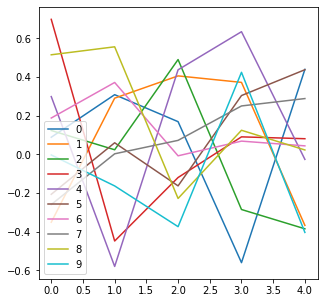

In [19]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

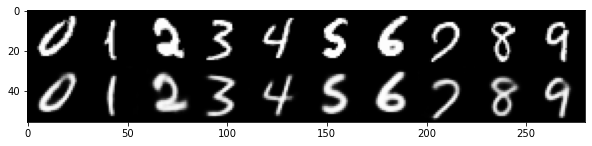

In [20]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [21]:
exn = 5

In [22]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

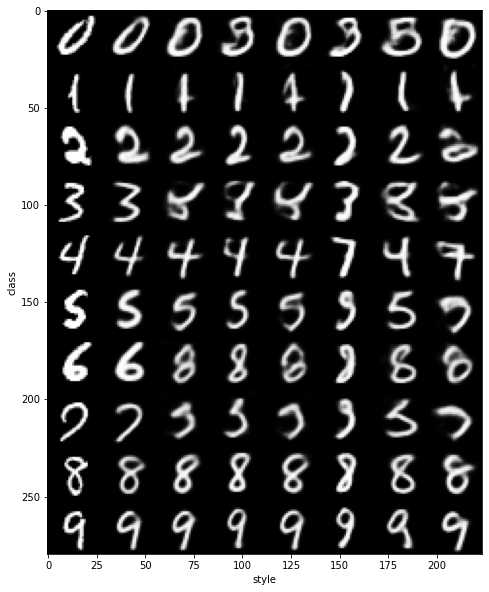

In [23]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [24]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

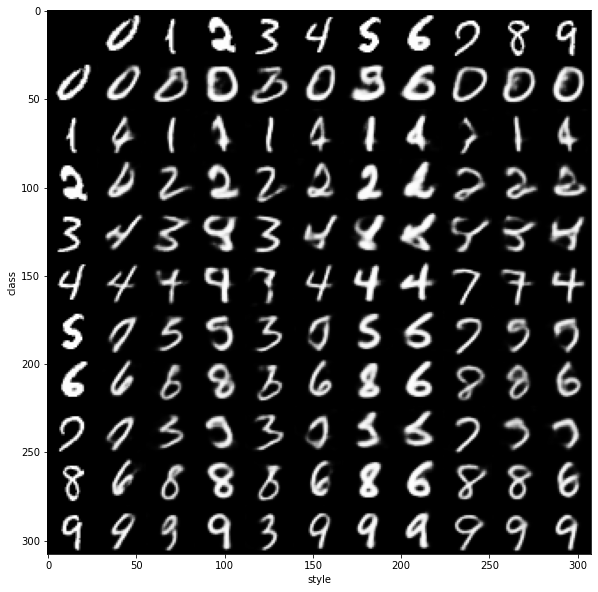

In [25]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()